<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P7%20-%20D%C3%A9veloppez%20une%20preuve%20de%20concept/D%C3%A9veloppez_une_preuve_de_concept_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Normalization, Resizing, Rescaling,\
    RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast,\
    Layer, Dense, Embedding, Input, LayerNormalization, MultiHeadAttention,\
    Add, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy,\
    SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
drive.mount("/content/gdrive", force_remount=False)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Répertoire de travail courant : /content/gdrive/MyDrive/Colab Notebooks


Pour mes premiers tests, j'utilise le jeu de données réduit issu du projet précédent, comportant des photos de 12 races de chiens.

In [3]:
dataset_12 = "./images_12/"
width, height = 72, 72  # OoM avec 224x224 x 8 patch-size & 112x112 x 6 patch-size
input_shape = (width, height, 3)
batch_size = 256
train_12 = image_dataset_from_directory(
  dataset_12,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_12 = image_dataset_from_directory(
  dataset_12,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
class_names = train_12.class_names
num_classes = len(class_names)
print(class_names)

Found 2648 files belonging to 12 classes.
Using 2119 files for training.
Found 2648 files belonging to 12 classes.
Using 529 files for validation.
['n02085936-Maltese_dog', 'n02086240-Shih_Tzu', 'n02088094-Afghan_hound', 'n02090721-Irish_wolfhound', 'n02092002-Scottish_deerhound', 'n02097474-Tibetan_terrier', 'n02107683-Bernese_mountain_dog', 'n02110806-basenji', 'n02111129-Leonberg', 'n02111500-Great_Pyrenees', 'n02111889-Samoyed', 'n02112018-Pomeranian']


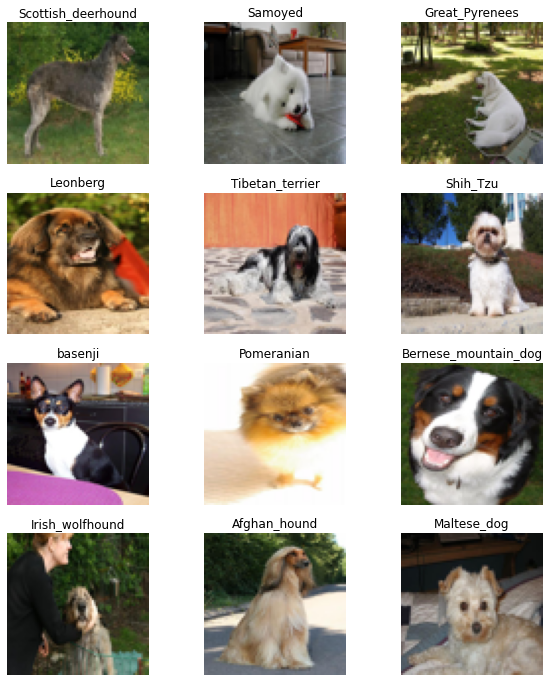

In [4]:
# Lecture des images du dataset
plt.figure(figsize=(10, 12))
i = 1
for sub_dir in os.listdir(dataset_12):
    sub_dir_images = os.listdir(dataset_12 + sub_dir)
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 12 and j == 0:
            image = os.path.join(dataset_12, sub_dir, sub_dir_image)
            img = Image.open(image) 
            img_resized = img.resize((width, height))
            plt.subplot(4, 3, i)
            plt.axis('off')
            race = sub_dir.split('-')[1]
            plt.title(race)
            plt.imshow(img_resized)
            i = i + 1
            j = j + 1
plt.show()

In [5]:
def concat_batchs(dataset):
  """
  Charge en mémoire le jeu de données batché
  """
  x_ds = None
  y_ds = None
  for image_batch, labels_batch in tqdm(dataset):
      if x_ds == None:
          x_ds = image_batch
          y_ds = labels_batch
      else:
          x_ds = tf.concat(axis=0, values = [x_ds, image_batch])
          y_ds = tf.concat(axis=0, values = [y_ds, labels_batch])
  return (x_ds, y_ds)

(x_train, y_train) = concat_batchs(train_12)
(x_test, y_test) = concat_batchs(val_12)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

x_train shape: (2119, 72, 72, 3) - y_train shape: (2119,)
x_test shape: (529, 72, 72, 3) - y_test shape: (529,)


Configuration des hyper-paramètres

In [6]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100
patch_size = 6  # taille des patchs (largeur/hauteur)
num_patches = (width // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # dimension des couches Transformer
transformer_layers = 8  # nb de couches Transformer
mlp_head_units = [2048, 1024]  # Dimensions couches Dense du classifier final

Préparation de la data augmentation

In [7]:
data_augmentation = Sequential([
    Normalization(),
    Resizing(width, height),
    RandomFlip("horizontal", input_shape=input_shape),
    RandomRotation(factor=0.4, fill_mode="wrap"),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
    RandomContrast(factor=0.2)
  ],
  name="data_augmentation"
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Implémentation d'un perceptron multi-couches (multilayer perceptron - MLP)

In [8]:
def mlp(x, hidden_units, dropout_rate):
    """
    Renvoie un MLP - Perceptron multi-couches
    Parameters:
        x (Layer): La couche après laquelle insérer le MLP
        hidden_units (int): Le nombre de couches Dense+Dropout à insérer
        dropout_rate (int): le paramètre passé aux couches Dropout insérées
    Returns:
        x (Layer): La dernière couche du MLP
    """
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

Implementation de la création de patchs via une surcharge de la classe Layer

In [9]:
class Patches(Layer):
    """
    Classe de type Layer gérant la création de patchs
    """
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Affiche les patches sur une première image

In [10]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


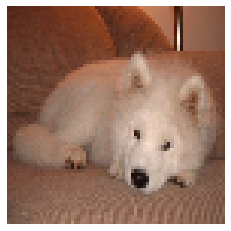

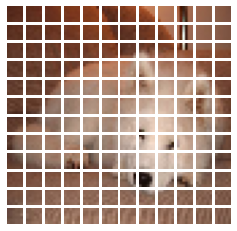

In [11]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(width, height)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {width} X {height}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Implémentation de la couche d'encodage du patch

La couche PatchEncoder va effectuer une transformation linéaire du patch en réalisation sa projection vers un vecteur de taille projection_dim.

Sur ce vecteur, il ajoute un embedding de position entrainable.

In [12]:
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Construction du modèle ViT (Vision Transformer)

Le modèle ViT est composé de plusieurs blocs Transformer.
La couche MultiHeadAttention est un mécanisme de self-attention applié aux patchs. Les blocs Transformer produisent un tensor de dimensions [batch_size, num_patches, projection_dim], qui est traité par un classifieur de type softmax qui renvoie en sortie les probabilité de classes.

Le traitement final de la sortie n'est pas tout à fait celle décrite dans le papier de recherche : les sorties du dernier bloc Transformer passent par layers.Flatten().

On pourrait également utiliser layers.GlobalAveragePooling1D pour aggréger les sorties du bloc Transformer, surtout si le nombre de patchs et les dimensions de projection sont grandes.

In [18]:
def create_vit_classifier(num_classes):
    inputs = Input(shape=input_shape)
    # data augmentation
    augmented = data_augmentation(inputs)
    # création des patchs
    patches = Patches(patch_size)(augmented)
    # encodage des patchs
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Création des couches du bloc Transformer
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # MultiHeadAttention
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = Add()([x3, x2])

    # création du tensor [batch_size, projection_dim]
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)
    # ajout du MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # sortie du classifier
    logits = Dense(num_classes)(features)
    # création du modèle final
    model = Model(inputs=inputs, outputs=logits)
    return model

Compilation, train et évaluation du modèle

In [14]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            SparseCategoricalAccuracy(name="accuracy"),
            SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier(12)
history = run_experiment(vit_classifier)

Epoch 1/100
8/8 [==============================] - 17s 567ms/step - loss: 5.0519 - accuracy: 0.0986 - top-5-accuracy: 0.4468 - val_loss: 2.5314 - val_accuracy: 0.1085 - val_top-5-accuracy: 0.5377
Epoch 2/100
8/8 [==============================] - 3s 350ms/step - loss: 2.9335 - accuracy: 0.1064 - top-5-accuracy: 0.4683 - val_loss: 2.4573 - val_accuracy: 0.1179 - val_top-5-accuracy: 0.4858
Epoch 3/100
8/8 [==============================] - 3s 351ms/step - loss: 2.6805 - accuracy: 0.1122 - top-5-accuracy: 0.4819 - val_loss: 2.4169 - val_accuracy: 0.1651 - val_top-5-accuracy: 0.5613
Epoch 4/100
8/8 [==============================] - 2s 245ms/step - loss: 2.6057 - accuracy: 0.1127 - top-5-accuracy: 0.5045 - val_loss: 2.4313 - val_accuracy: 0.1557 - val_top-5-accuracy: 0.5519
Epoch 5/100
8/8 [==============================] - 2s 245ms/step - loss: 2.4878 - accuracy: 0.1311 - top-5-accuracy: 0.5391 - val_loss: 2.4195 - val_accuracy: 0.1226 - val_top-5-accuracy: 0.6085
Epoch 6/100
8/8 [=======

J'arrive à une accuracy de 31% sur le jeu de validation, ce qui est plutôt bon sans avoir fait de transfer learning !

Je fais le test sur 120 classes (120 races de chiens du dataset) :

In [15]:
dataset_dir = "./images/"
batch_size = 32
train_ds = image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_ds = image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


J'approche les 12% d'accuracy sur les 120 races, ce qui correspond aux meilleurs résultats sur un CNN "hors transfer learning" entrainé sur le même jeu de données, et optimisé via Keras Tuner.

On peut remarquer qu'ici je n'ai pas fait d'optimisation des hyper-paramètres.



In [19]:
vit_classifier_120 = create_vit_classifier(120)

optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

vit_classifier_120.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        SparseCategoricalAccuracy(name="accuracy"),
        SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = vit_classifier_120.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=[checkpoint_callback]
)

vit_classifier_120.load_weights(checkpoint_filepath)

Epoch 1/100
515/515 [==============================] - 58s 88ms/step - loss: 4.9827 - accuracy: 0.0094 - top-5-accuracy: 0.0422 - val_loss: 4.7846 - val_accuracy: 0.0107 - val_top-5-accuracy: 0.0556
Epoch 2/100
515/515 [==============================] - 44s 85ms/step - loss: 4.7907 - accuracy: 0.0117 - top-5-accuracy: 0.0542 - val_loss: 4.7844 - val_accuracy: 0.0090 - val_top-5-accuracy: 0.0520
Epoch 3/100
515/515 [==============================] - 43s 82ms/step - loss: 4.7862 - accuracy: 0.0123 - top-5-accuracy: 0.0552 - val_loss: 4.7839 - val_accuracy: 0.0104 - val_top-5-accuracy: 0.0537
Epoch 4/100
515/515 [==============================] - 43s 83ms/step - loss: 4.7866 - accuracy: 0.0123 - top-5-accuracy: 0.0545 - val_loss: 4.7837 - val_accuracy: 0.0104 - val_top-5-accuracy: 0.0534
Epoch 5/100
515/515 [==============================] - 44s 84ms/step - loss: 4.7830 - accuracy: 0.0123 - top-5-accuracy: 0.0555 - val_loss: 4.7869 - val_accuracy: 0.0112 - val_top-5-accuracy: 0.0498
Epoch

On atteint les 12% d'accuracy en validation. C'est quasiment le même score qu'avec un CNN optimisé via Keras Tuner, mais là on n'a pas fait d'optimisation des hyper-paramètres.

On peut conclure que sur un jeu de donnée avec un aussi faible volume, le transfer learning reste la meilleure option.

Maintenant, est-il possible de faire du transfer learning depuis un modèle de type ViT ?
